# Using Python To Fit Molecular Conduction Data

## The Single Level Tunneling Model

I won't go indepth into the various theories that I've used to describe conduction through molecular junctions here. I also won't dicuss the theoretical meanings for each of the parameters. For those explanations please refer to my thesis. Here I will solely focus on the implentation of the theories into python code. I'll start with the mathematical equation for the single level tunneling model. Let's start with the landauer equation as given in equations (1.9) and (1.10) of my thesis. We'll start with the non-Gaussian version and expand to include it later.

$$I = \dfrac{q}{\hbar}\int_{-\infty}^{\infty}dE D_\epsilon(E)\Gamma\left[f_L(E)-f_R(E)\right]$$

Where:

$$D_\epsilon(E) = \dfrac{\dfrac{\gamma_L+\gamma_R}{2}}{\left(E-\left(\epsilon+\left(\eta-\dfrac{1}{2}\right)\right)\right)^2+\left(\dfrac{\gamma_L+\gamma_R}{2}\right)^2}$$
<br>
<br>
$$\Gamma = \dfrac{\gamma_L\gamma_R}{\gamma_L+\gamma_R}$$
<br>
<br>
$$f_{L/R}(E) = \dfrac{1}{1+e^\frac{E+/-v_b/2}{k_bT}}$$
<br>
<br>
We're going to simplify the current equation a little:
<br>
<br>
<br>
$$I = \dfrac{q\gamma_c}{2\hbar}\int_{-\infty}^{\infty} \dfrac{f_L(E)-f_R(E)}{\left(E-\left(\epsilon+\left(\eta-\frac{1}{2}\right)v\right)\right)^2+\left(\frac{\gamma_w}{2}\right)^2}dE$$
<br>
<br>
<br>
So this simplified version makes things a little easier to see what's going on. I've defined the variables $\gamma_c = \gamma_L\gamma_R$ and $\gamma_w = \gamma_L+\gamma_R$. To make things easier. Note that $\gamma_c$ sits outside of the integral so it is linearly related to the current. While $\gamma_w$ sits inside the integral within the lorentzian and therefore adjusts the width of the transition at resonance. $\gamma_L$ and $\gamma_R$ each change both the amplitude of current and the width of the resonance. This makes manual manipulation of the fit more challenging rather than having a single amplitude parameter and single width parameter. You can always convert back to $\gamma_L$ and $\gamma_R$.

$$\gamma_L = \frac{1}{2}\left(\gamma_w-\sqrt{\gamma_w^2-4\gamma_c}\right)$$

$$\gamma_R = \frac{1}{2}\left(\gamma_w+\sqrt{\gamma_w^2-4\gamma_c}\right)$$

Note the condition here, the square root can not have a negative number. so make sure this condition applies if using these version to fit data.

So now that we have the equation. How do we code it into python? Let's do that.

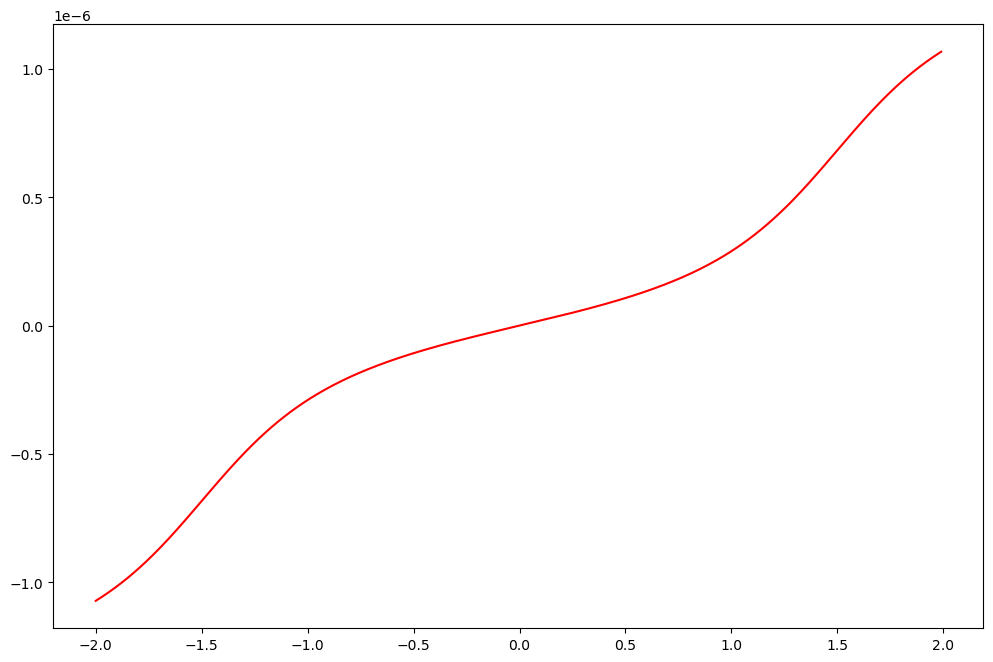

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
from scipy.integrate import quad

eV = 1
K  = 1
C  = 1
s  = 1
kb = 8.6173324e-5*eV/K #Boltzmann Constant
q  = 1.6e-19*C
h  = 4.1356e-15*eV*s/(2*np.pi)

def fermi(E,T):
    return 1/(np.exp((E)/(kb*T))+1)

def landauerCurrent(vb, gammaC, gammaW, epsilon, eta, T):
    prefactor = -q*gammaC/(2*h)
    def integrand(E):
        return (fermi(E+vb/2,T)-fermi(E-vb/2,T))/(((E-epsilon+(eta-1/2)*vb)**2+(gammaW/2)**2))
    
    return prefactor*quad(integrand,-10,10)[0]

V = np.arange(-2,2,.01)
vecCurrent = np.vectorize(landauerCurrent)

I = vecCurrent(V, 0.001,0.5,0.75,0.5, 300)
plt.figure()
plt.plot(V,I, color = 'red')

So here we have a represtentative current profile for a single molecule junction. As I said before, I'm not including a Gausian just yet. I'm going to go through the parameters used and show what effect they have on the curve.

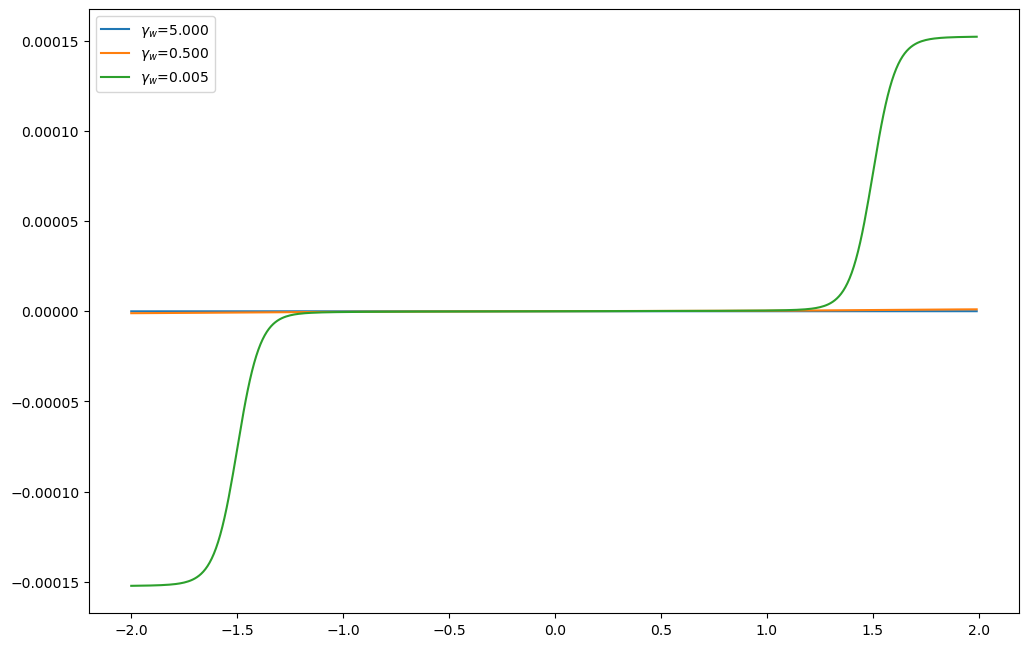

In [16]:
plt.figure()
gammaWValues = [5,0.5,0.005]
for gammaW in gammaWValues:
    I = vecCurrent(V, 0.001,gammaW,0.75,0.5, 300)
    plt.plot(V,I, label = '$\gamma_w$=%.3f'%gammaW)
plt.legend()

## Fitting Basics

There are several different ways to fit data in python. The package I've used in the work for my thesis for fitting is [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html).

<p>There are 4 main functions I've used for minimization. However, there are many to choose from which might provide better results depending on the situation.</p>

1. [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit)

2. [scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares)

3. [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

4. [scipy.optimize.differential_evolution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolution)

Let me show how each of these is used.

First we'll start with defining a simple function, and plotting it.

### Linear Function

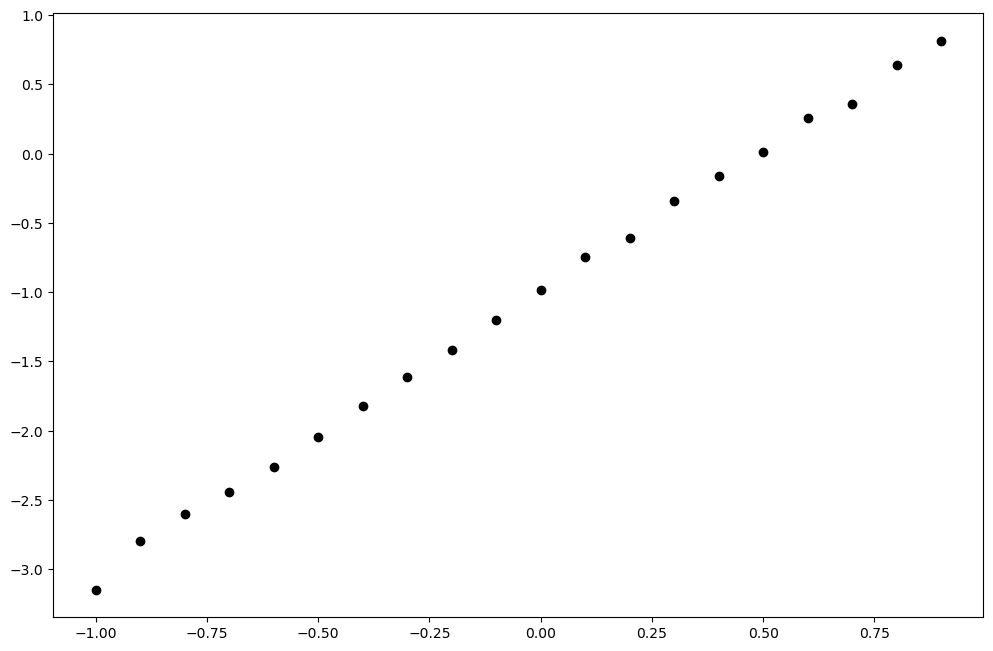

In [1]:
import scipy.stats as stats

# Defining Function
def linear(x,m,b):
    return m*x+b
vecLinear = np.vectorize(linear) #Vectorize function

# These are our the values of r our linear parameters
m = 2
b = -1
msig = 0.05
bsig = 0.05

# These are the x values we will use
X = np.arange(-1,1,.1)

# The M and B values are randomized using the normal distribution provided by scipy.stats
M = stats.norm.rvs(loc = m, scale = msig, size = len(X))
B = stats.norm.rvs(loc = b, scale = bsig, size = len(X))

# Calculating Y
Y = vecLinear(X,M,B)

# Plotting our 'Experimental' values
plt.figure('Linear Fit')
plt.scatter(X,Y, color = 'black')

Here we define a function "linear" we use [numpy](https://numpy.org/) to 'vectorize' the function. In other words, after we 'vectorize' the function we can start making the arguments lists rather than just scalars. 

Next we define our slope and y-interecept (m and b). However, since we're experimentalists and no data is ever perfect, we add some noise to our two variables using the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) function "norm". This is a 'normal distribution centered at the values for m and b.

Finally we use the randomized values for m and b, to calculate Y from our vectorized linear function and we plot Y vs X in the scatter plot. Since this is randomaized, each time you run the cell you'll get a slightly different result. Overall though it should like like a linear line with a little noise added to it. Now we're going to attempt to fit that line using the first method listed above: curve_fit

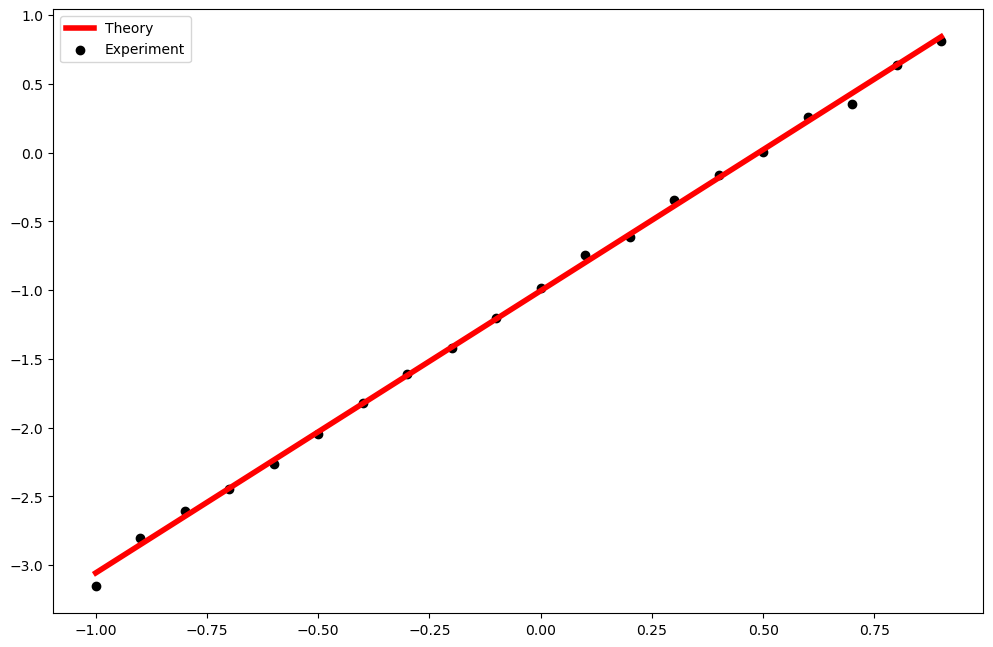

In [2]:
import scipy.optimize as sco

# Fitting with sco.curve_fit
pars, cov = sco.curve_fit(linear,X,Y)

# Calculate Y using the parameters determined by curve_fit
Ythr = vecLinear(X,*pars)

# Plotting the 'Experiment' vs the 'Theory'
plt.figure('Linear Fit')
plt.scatter(X,Y, color = 'black', label = 'Experiment')
plt.plot(X,Ythr,color = 'red', label = 'Theory', linewidth = 4)
plt.legend()

Alright so it looks like it did a decent job of fitting the data. However, what were the exact values of the parameters and how close were they to the values we gave?

In [3]:
mFit = pars[0]
bFit = pars[1]

parErrs = np.sqrt(np.diag(cov))
mThrErr = parErrs[0]
bThrErr = parErrs[1]

Output = 'The parameters are:\n'
Output += '\tExp\t\tThry\n'
Output += u'm:\t%.2f \u00B1 %.2f\t%.2f \u00B1 %.2f\n' %(m,msig,mFit,mThrErr)
Output += u'b:\t%.2f \u00B1 %.2f\t%.2f \u00B1 %.2f'   %(b,bsig,bFit,bThrErr)
print(Output)

The parameters are:
	Exp		Thry
m:	2.00 ± 0.05	2.05 ± 0.02
b:	-1.00 ± 0.05	-1.00 ± 0.01


So as we can see here, the fitted values are within 1 standard deviation of the 'experimental' values. As desired.

### A Little More Complicated

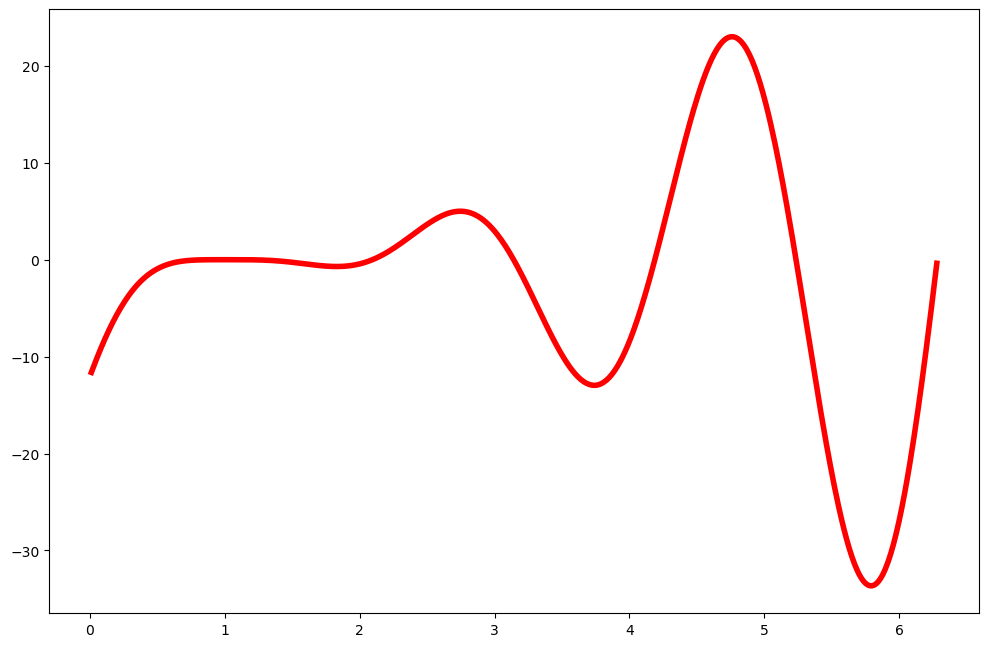

In [4]:
def complicated(x,A,B,C):
    return ((A-x)**3)*np.sin(B*x)/(1-np.exp(C*x))
vecComp = np.vectorize(complicated)

a = 1
b = 3
c = .25


X = np.arange(0.01,2*np.pi,.01)
YExac = vecComp(X,a,b,c)

plt.figure()
plt.plot(X,YExac,color = 'red', linewidth = 4)

I created the 'complicated' function. It's just a random asortment of functions all thrown into one. Now, we're going to randomize it a bit just like we did last time and we'll fit it all.

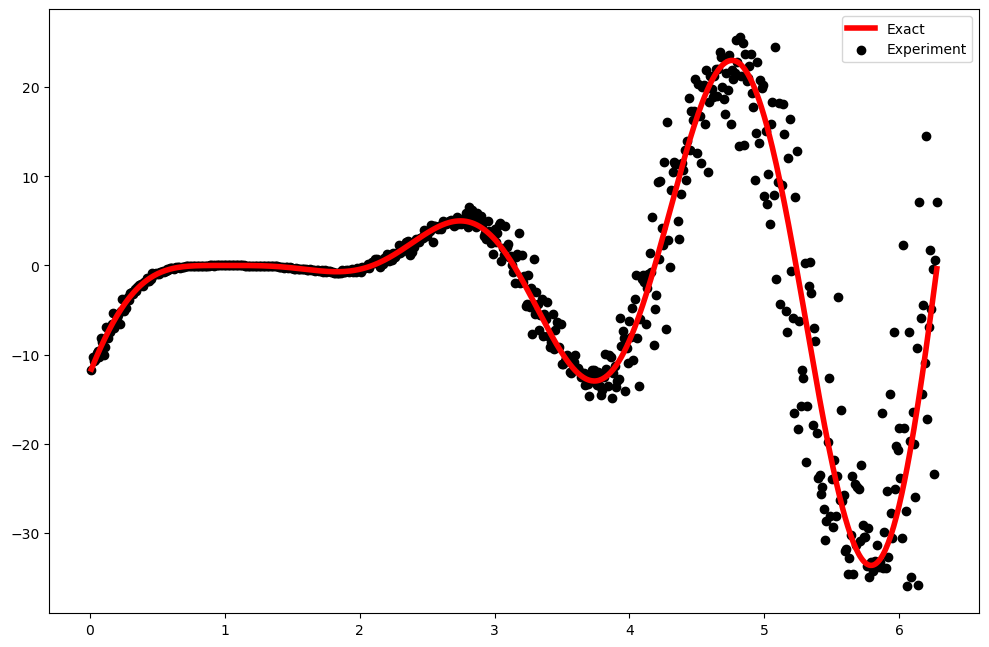

In [5]:
Offset = 0.025

A = stats.norm.rvs(loc = a, scale = a*Offset, size = len(X))
B = stats.norm.rvs(loc = b, scale = b*Offset, size = len(X))
C = stats.norm.rvs(loc = c, scale = c*Offset, size = len(X))

YExp = vecComp(X,A,B,C)

plt.figure()
plt.scatter(X,YExp,color = 'black', label = 'Experiment')
plt.plot(X,YExac, color = 'red', label = 'Exact', linewidth = 4)
plt.legend()

By adjusting the 'offset' here we can change the dispersion of the points. A larger offset will cause this to be more difficult to fit. Now that we have our complicated function with our complicated data points. Lets first start with curve_fit and move on down the line

#### Fitting with curve_fit()

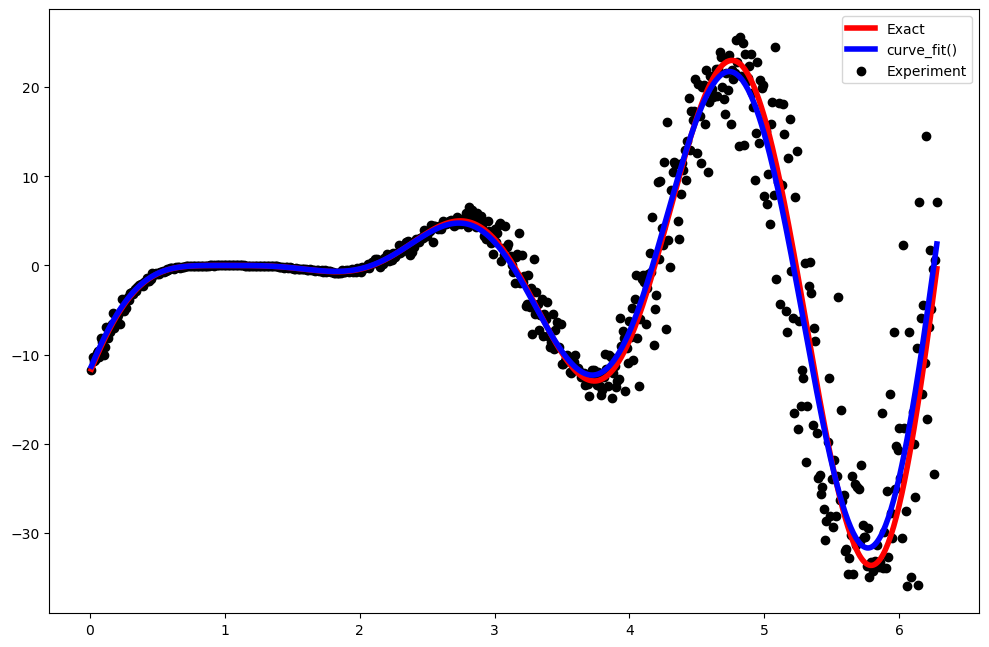

In [22]:
#initial Parameters
Initpars = [0,2.50,0.70]

# Fitting with sco.curve_fit
pars, cov = sco.curve_fit(complicated,X,YExp, p0=Initpars)

# Calculate Y using the parameters determined by curve_fit
Y_CF = vecComp(X,*pars)

plt.figure()
plt.scatter(X,YExp,color = 'black', label = 'Experiment')
plt.plot(X,YExac, color = 'red', label = 'Exact', linewidth = 4)
plt.plot(X,Y_CF, color = 'blue', label = 'curve_fit()', linewidth = 4)
plt.legend()

Well that didn't quite get us the result we wanted. Let's try least squares next.

#### Fitting with least_squares()

Fitting with least_squares() isn't as easy as working with curve_fit(). We have to take the difference or residual between the experimental data and the calculated date.

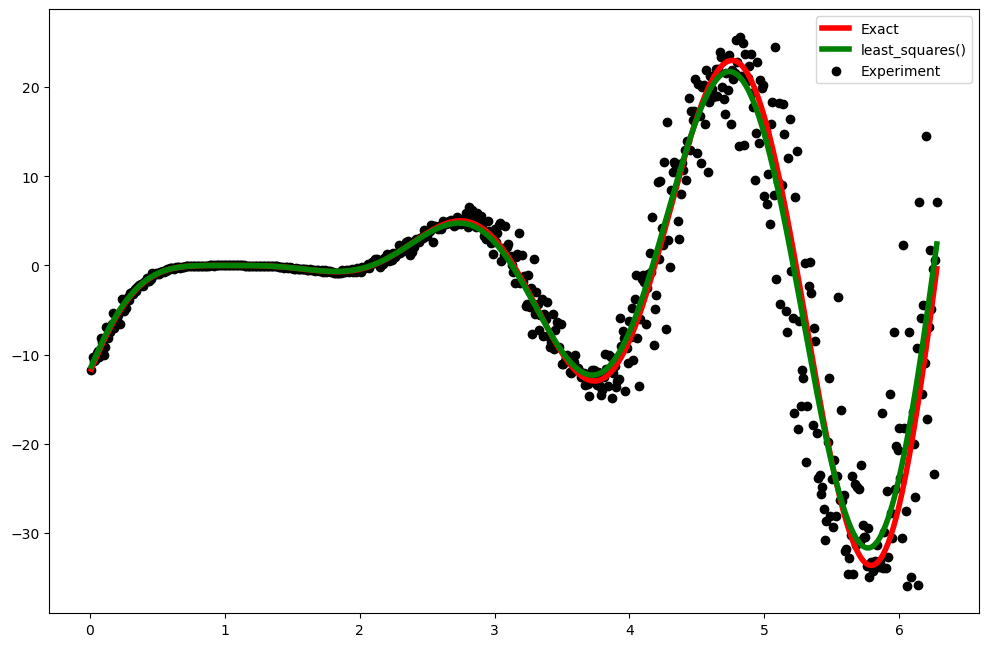

In [7]:
def minfunc(args):
    Y_LS = vecComp(X,*args)
    res = np.subtract(Y_LS,YExp)
    return res

# Fitting with sco.curve_fit
result = sco.least_squares(minfunc,x0=Initpars)

# Calculate Y using the parameters determined by curve_fit
Y_LS = vecComp(X,*result.x)

plt.figure()
plt.scatter(X,YExp,color = 'black', label = 'Experiment')
plt.plot(X,YExac, color = 'red', label = 'Exact', linewidth = 4)
plt.plot(X,Y_LS, color = 'green', label = 'least_squares()', linewidth = 4)
plt.legend()

So we see here that least_squares() and curve_fit() give us very similar results. In fact curve_fit(), calls the least_squares() function. The main difference between the two is the 'minfunc' that is required for least_squares(). This 'minfunc' needs to only take the parameters are arguments and needs to ouput the residual.

#### Fitting with minimize()

Now we're going to fit with the 'minimize()' function. Now again this function also wants a different format for it's arguments. In this case, the 'minimize()' function wants a function to minimize. In other words, the user most provide a function that provides a single scalar value that 'minimize()' will try to make as small as possible.

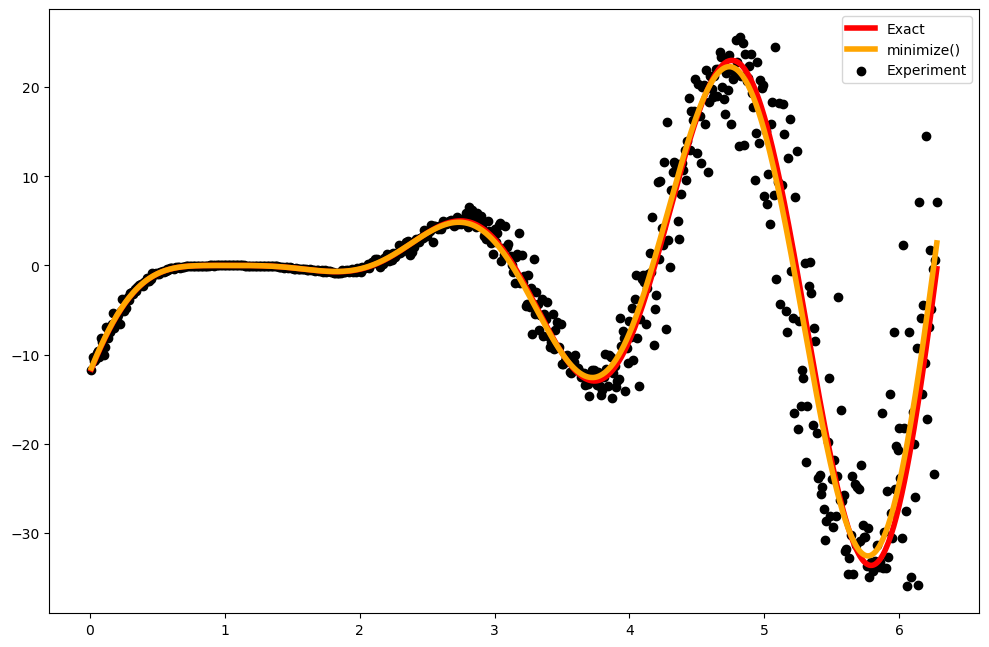

In [23]:
def minfunc(args):
    Y_LS = vecComp(X,*args)
    res = np.subtract(Y_LS,YExp)
    return np.sum(np.sqrt(res**2))

# Fitting with sco.curve_fit
result = sco.minimize(minfunc,x0=Initpars)

# Calculate Y using the parameters determined by curve_fit
Y_min = vecComp(X,*result.x)

plt.figure()
plt.scatter(X,YExp,color = 'black', label = 'Experiment')
plt.plot(X,YExac, color = 'red', label = 'Exact', linewidth = 4)
plt.plot(X,Y_min, color = 'orange', label = 'minimize()', linewidth = 4)
plt.legend()

#### Fitting with differential_evolution()

The differential_evolution algorithm can use the same 'minfunc()' that 'minimize()' uses, but instead of taking initial parameters, the differential_evolution function only uses bounds. Which I haven't touched on yet, but can be utilized in each of the fitting methods dicussed above.

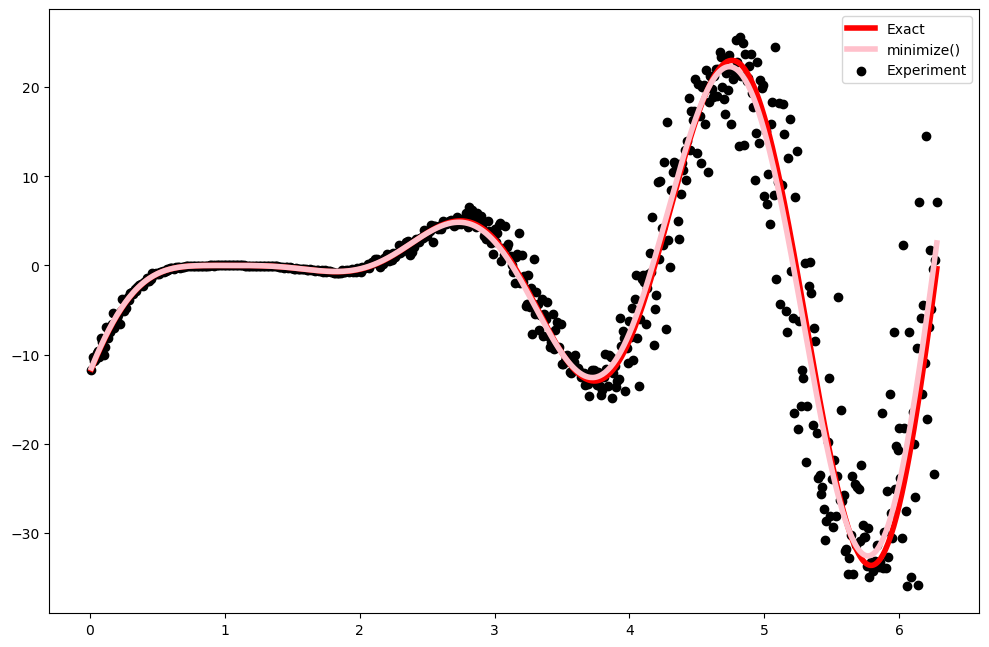

In [30]:
def minfunc(args):
    Y_LS = vecComp(X,*args)
    res = np.subtract(Y_LS,YExp)
    return np.sum(np.sqrt(res**2))

bounds = [[0.01,10],[0.01,10],[0.01,10]]

# Fitting with sco.curve_fit
result = sco.differential_evolution(minfunc,bounds = bounds)

# Calculate Y using the parameters determined by curve_fit
Y_diff = vecComp(X,*result.x)

plt.figure()
plt.scatter(X,YExp,color = 'black', label = 'Experiment')
plt.plot(X,YExac, color = 'red', label = 'Exact', linewidth = 4)
plt.plot(X,Y_diff, color = 'pink', label = 'diff_evo()', linewidth = 4)
plt.legend()

So as you can see here the 'differential_evolution()' algorthim converges to the right answer despite not receiving initial parameters and having very wide bounds \[0.01,10\]. However, there is one main problem with this method, it takes a much longer time to converge than any of the other methods discussed. We'll wrap up this section with a review of all the methods and comparing them with one another.

#### Review of Methods

Now that we've shown that each of the fitting methods does indeed work we'll find the points at which they break. We'll also compare the calculation time or each method. I'm also going to introduce dictionaries to keep track of variables. It's really sooo much eaiser. Also, one last thing, I won't be fitting with curve_fit() because it actually calls least_squares() during the fitting process.

##### Fitting All

Summary of Results
	Method			Error		Time
	Exact			1405.72		3.99ms
	least_squares		1388.78		0.18s
	minimized		1378.27		1.37s
	differential_evolution	1378.52		3.11s



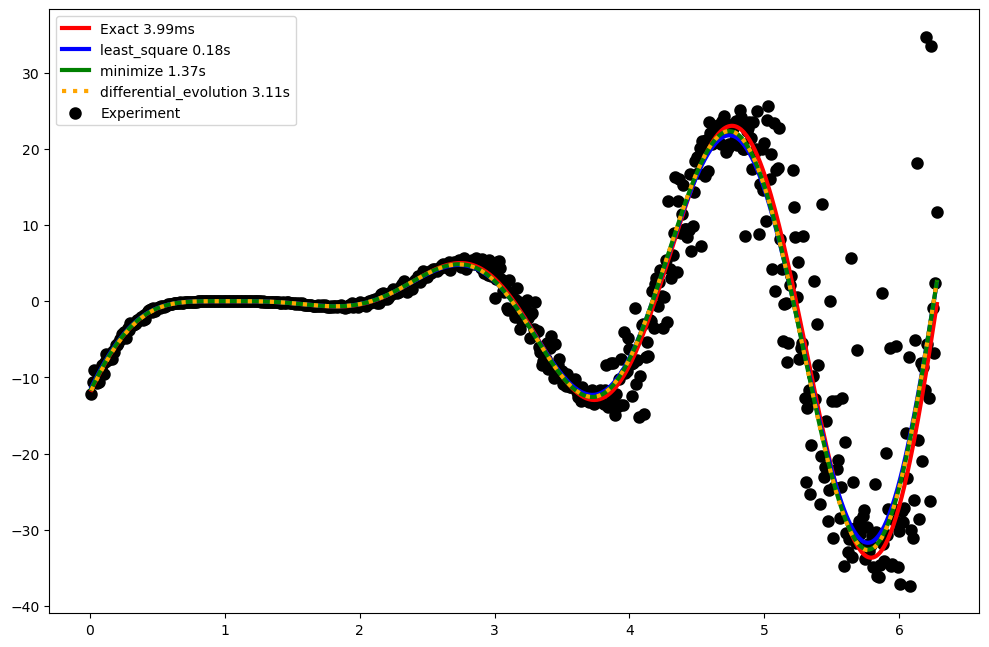

In [57]:
import time
def complicated(x,A,B,C):
    return ((A-x)**3)*np.sin(B*x)/(1-np.exp(C*x))
vecComp = np.vectorize(complicated)

ExactParams = {
    'A' : 1.00,
    'B' : 3.00,
    'C' : 0.25
}

InitParams = {
    'A' : 0.00,
    'B' : 2.50,
    'C' : 0.70
}

Bounds = {
    'A' : [0.01, 4],
    'B' : [0.01, 4],
    'C' : [0.01, 4]
}

Exp_Noise = 0.025 #The 'experimental' Noise

# Setting up X
X = np.arange(0.01,2*np.pi,.01)

# Setting up the Experimetnal Y values
A = stats.norm.rvs(loc = a, scale = a*Exp_Noise, size = len(X))
B = stats.norm.rvs(loc = b, scale = b*Exp_Noise, size = len(X))
C = stats.norm.rvs(loc = c, scale = c*Exp_Noise, size = len(X))

# Calculating the Experimental Y and Exact Y values:
Y_Exp    = vecComp(X,A,B,C)

# Setting up the two different minfuncs that will need to be used. Note the differences.
def minfunc_res(args):
    Y_LS = vecComp(X,*args)
    res = np.subtract(Y_LS,YExp)
    return res

def minfunc_diff(args):
    Y_LS = vecComp(X,*args)
    res = np.subtract(Y_LS,YExp)
    return np.sum(np.sqrt(res**2))

# Doing all the Fits and timing them
start         = time.time()
Y_Exac        = vecComp(X,*ExactParams.values())
time_Exac     = time.time()-start

start         = time.time()
result_LS     = sco.least_squares(minfunc_res,x0=list(InitParams.values()))
time_LS       = time.time()-start

start         = time.time()
result_min    = sco.minimize(minfunc_diff,x0=list(InitParams.values()))
time_min      = time.time()-start

start         = time.time()
result_diff   = sco.differential_evolution(minfunc_diff,bounds = list(Bounds.values()))
time_diff     = time.time()-start

# Calculate the Y values for each fit:
Y_LS    = vecComp(X,*result_LS.x)
Y_min   = vecComp(X,*result_min.x)
Y_diff  = vecComp(X,*result_diff.x)

# Calculate the Errors for each fit
Err_Exac  = minfunc_diff(list(ExactParams.values()))
Err_LS    = minfunc_diff(result_LS.x)
Err_min   = result_min.fun
Err_diff  = result_diff.fun

#Plotting all of the results:
plt.figure()
plt.scatter(X, Y_Exp,  color = 'black',  linewidth = 3, label= 'Experiment')
plt.plot(   X, Y_Exac, color = 'red',    linewidth = 3, label= 'Exact %.2fms'%(time_Exac*1000))
plt.plot(   X, Y_LS,   color = 'blue',   linewidth = 3, label= 'least_square %.2fs'%time_LS)
plt.plot(   X, Y_min,  color = 'green',  linewidth = 3, label= 'minimize %.2fs'%time_min)
plt.plot(   X, Y_diff, color = 'orange', linewidth = 3, label= 'differential_evolution %.2fs'%time_diff, linestyle = 'dotted')
plt.legend()

output = 'Summary of Results\n'
output += '\tMethod\t\t\tError\t\tTime\n'
output += '\tExact\t\t\t%.2f\t\t%.2fms\n'%(Err_Exac,time_Exac*1000)
output += '\tleast_squares\t\t%.2f\t\t%.2fs\n'%(Err_LS,time_LS)
output += '\tminimized\t\t%.2f\t\t%.2fs\n'%(Err_min,time_min)
output += '\tdifferential_evolution\t%.2f\t\t%.2fs\n'%(Err_diff,time_diff)
print(output)

So we're going to take a look at this particular example. The exact results may be somewhat different on a different system and a different random seed.

First thing to note is that the time it takes to calculate the exact function is a few ms. Note this, because when calculating the landauer equation, the computation time can be increased significantly. This is due to calculation of the numerical integral. When we utilize the gaussian for SAM junctions, the computation time goes up exponentially due to it being a double numerical integral. This is why I'm doing this with a 'relatively' simple equation that has a short computation time.

Now on to the Fittings. The below Table is a copy of the Summary of Results produced for my system and random generator seed:


| Method                 	| Error   	| Time    	|
|------------------------	|---------	|---------	|
| Exact                  	| 1405.72 	| 3.99 ms 	|
| least_squares          	| 1388.78 	| 0.18 s  	|
| minimize               	| 1378.27 	| 1.37 s  	|
| differential_evolution 	| 1378.52 	| 3.11 s  	|

So I calculated the error, which is really just the summed difference between each theory point and each 'experimental' point. Note that the 'Exact' method has an error of 1405. This is due to the noise I added to the experimental data. This interestingly resulted in the fits being closer to the experimental data than the exact calculation. Note that least_squares was the least effective, but by far the fastest. It was roughly 7 times faster that doesn't look like much now but for more complicated functions 7 times could be the difference between 30 minutes and 3.5 hours. The minimize function and the differential_evolution functions got nearly the exact same error, but diff_evo took twice as long. However, diff_evo did not rely on a user's 'guess' it just needed the bounds of what's reasonable. This makes diff_evo very powerful. Let's now start to move the initial parameters further from the 'correct' values and see what happens.

##### Failure of least_squares()

Summary of Results
	Method			Error		Time
	Exact			1405.72		2.96ms
	least_squares		4503.41		0.20s
	minimized		1378.27		1.22s
	differential_evolution	1378.27		3.37s



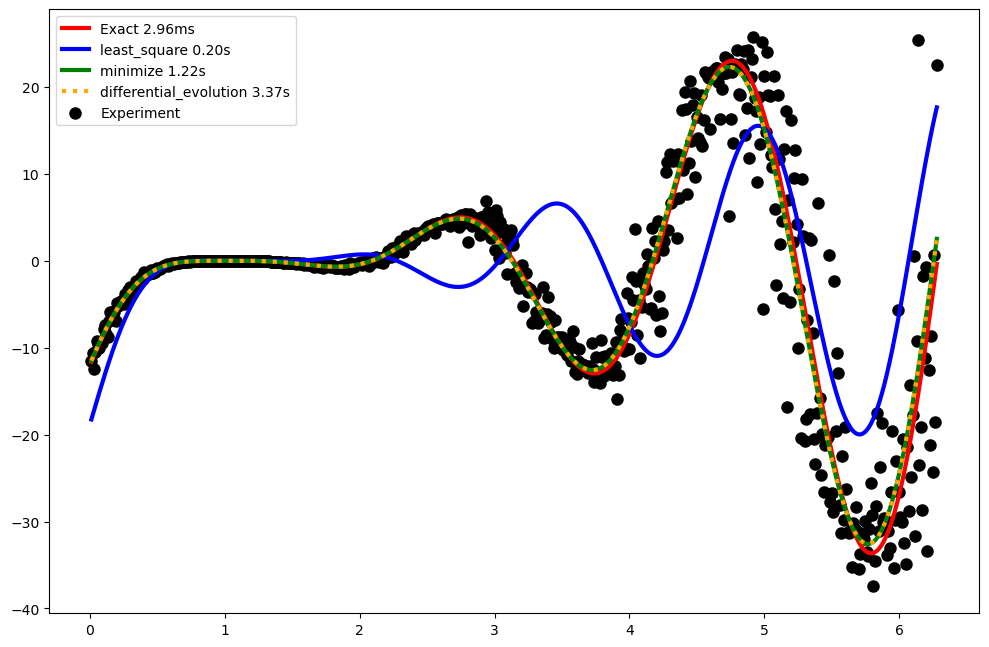

In [69]:
ExactParams = {
    'A' : 1.00,
    'B' : 3.00,
    'C' : 0.25
}

InitParams = {
    'A' : 0.00,
    'B' : 3.75,
    'C' : 0.70
}

Bounds = {
    'A' : [0.01, 4],
    'B' : [0.01, 4],
    'C' : [0.01, 4]
}

Exp_Noise = 0.025 #The 'experimental' Noise

# Setting up X
X = np.arange(0.01,2*np.pi,.01)

# Setting up the Experimetnal Y values
A = stats.norm.rvs(loc = a, scale = a*Exp_Noise, size = len(X))
B = stats.norm.rvs(loc = b, scale = b*Exp_Noise, size = len(X))
C = stats.norm.rvs(loc = c, scale = c*Exp_Noise, size = len(X))

# Calculating the Experimental Y and Exact Y values:
Y_Exp    = vecComp(X,A,B,C)

# Doing all the Fits and timing them
start         = time.time()
Y_Exac        = vecComp(X,*ExactParams.values())
time_Exac     = time.time()-start

start         = time.time()
result_LS     = sco.least_squares(minfunc_res,x0=list(InitParams.values()))
time_LS       = time.time()-start

start         = time.time()
result_min    = sco.minimize(minfunc_diff,x0=list(InitParams.values()))
time_min      = time.time()-start

start         = time.time()
result_diff   = sco.differential_evolution(minfunc_diff,bounds = list(Bounds.values()))
time_diff     = time.time()-start

# Calculate the Y values for each fit:
Y_LS    = vecComp(X,*result_LS.x)
Y_min   = vecComp(X,*result_min.x)
Y_diff  = vecComp(X,*result_diff.x)

# Calculate the Errors for each fit
Err_Exac  = minfunc_diff(list(ExactParams.values()))
Err_LS    = minfunc_diff(result_LS.x)
Err_min   = result_min.fun
Err_diff  = result_diff.fun

#Plotting all of the results:
plt.figure()
plt.scatter(X, Y_Exp,  color = 'black',  linewidth = 3, label= 'Experiment')
plt.plot(   X, Y_Exac, color = 'red',    linewidth = 3, label= 'Exact %.2fms'%(time_Exac*1000))
plt.plot(   X, Y_LS,   color = 'blue',   linewidth = 3, label= 'least_square %.2fs'%time_LS)
plt.plot(   X, Y_min,  color = 'green',  linewidth = 3, label= 'minimize %.2fs'%time_min)
plt.plot(   X, Y_diff, color = 'orange', linewidth = 3, label= 'differential_evolution %.2fs'%time_diff, linestyle = 'dotted')
plt.legend()

output = 'Summary of Results\n'
output += '\tMethod\t\t\tError\t\tTime\n'
output += '\tExact\t\t\t%.2f\t\t%.2fms\n'%(Err_Exac,time_Exac*1000)
output += '\tleast_squares\t\t%.2f\t\t%.2fs\n'%(Err_LS,time_LS)
output += '\tminimized\t\t%.2f\t\t%.2fs\n'%(Err_min,time_min)
output += '\tdifferential_evolution\t%.2f\t\t%.2fs\n'%(Err_diff,time_diff)
print(output)

In this instance, everything fits well except the least_squares fit.

##### Failure of minimize()

Summary of Results
	Method			Error		Time
	Exact			1405.72		2.01ms
	least_squares		1388.78		0.16s
	minimized		5211.44		0.45s
	differential_evolution	1378.28		2.95s



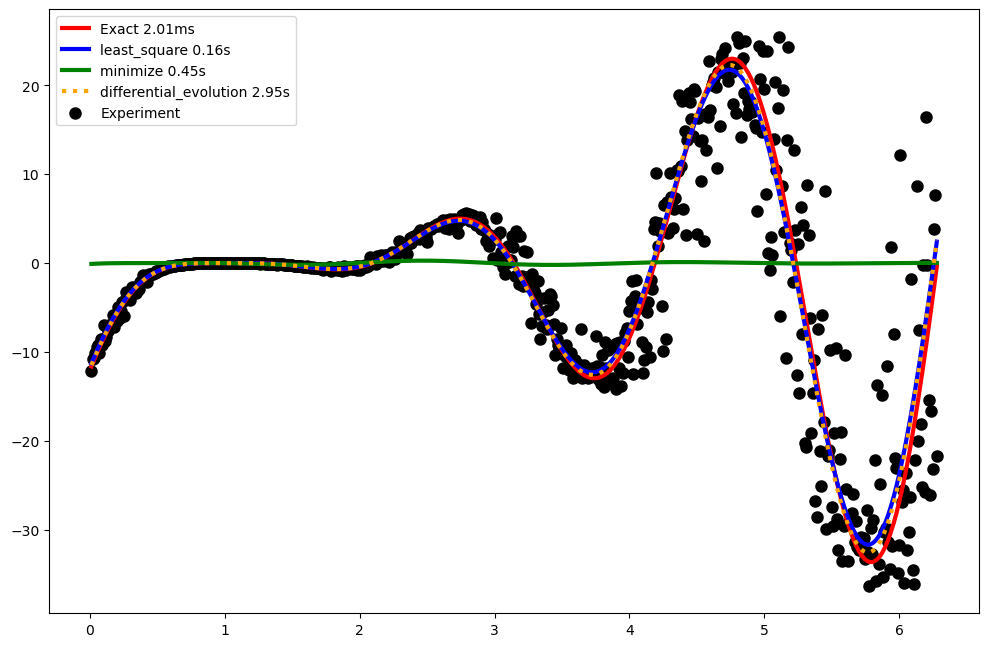

In [70]:
ExactParams = {
    'A' : 1.00,
    'B' : 3.00,
    'C' : 0.25
}

InitParams = {
    'A' : 0.00,
    'B' : 2.5,
    'C' : 0.75
}

Bounds = {
    'A' : [0.01, 4],
    'B' : [0.01, 4],
    'C' : [0.01, 4]
}

Exp_Noise = 0.025 #The 'experimental' Noise

# Setting up X
X = np.arange(0.01,2*np.pi,.01)

# Setting up the Experimetnal Y values
A = stats.norm.rvs(loc = a, scale = a*Exp_Noise, size = len(X))
B = stats.norm.rvs(loc = b, scale = b*Exp_Noise, size = len(X))
C = stats.norm.rvs(loc = c, scale = c*Exp_Noise, size = len(X))

# Calculating the Experimental Y and Exact Y values:
Y_Exp    = vecComp(X,A,B,C)

# Doing all the Fits and timing them
start         = time.time()
Y_Exac        = vecComp(X,*ExactParams.values())
time_Exac     = time.time()-start

start         = time.time()
result_LS     = sco.least_squares(minfunc_res,x0=list(InitParams.values()))
time_LS       = time.time()-start

start         = time.time()
result_min    = sco.minimize(minfunc_diff,x0=list(InitParams.values()))
time_min      = time.time()-start

start         = time.time()
result_diff   = sco.differential_evolution(minfunc_diff,bounds = list(Bounds.values()))
time_diff     = time.time()-start

# Calculate the Y values for each fit:
Y_LS    = vecComp(X,*result_LS.x)
Y_min   = vecComp(X,*result_min.x)
Y_diff  = vecComp(X,*result_diff.x)

# Calculate the Errors for each fit
Err_Exac  = minfunc_diff(list(ExactParams.values()))
Err_LS    = minfunc_diff(result_LS.x)
Err_min   = result_min.fun
Err_diff  = result_diff.fun

#Plotting all of the results:
plt.figure()
plt.scatter(X, Y_Exp,  color = 'black',  linewidth = 3, label= 'Experiment')
plt.plot(   X, Y_Exac, color = 'red',    linewidth = 3, label= 'Exact %.2fms'%(time_Exac*1000))
plt.plot(   X, Y_LS,   color = 'blue',   linewidth = 3, label= 'least_square %.2fs'%time_LS)
plt.plot(   X, Y_min,  color = 'green',  linewidth = 3, label= 'minimize %.2fs'%time_min)
plt.plot(   X, Y_diff, color = 'orange', linewidth = 3, label= 'differential_evolution %.2fs'%time_diff, linestyle = 'dotted')
plt.legend()

output = 'Summary of Results\n'
output += '\tMethod\t\t\tError\t\tTime\n'
output += '\tExact\t\t\t%.2f\t\t%.2fms\n'%(Err_Exac,time_Exac*1000)
output += '\tleast_squares\t\t%.2f\t\t%.2fs\n'%(Err_LS,time_LS)
output += '\tminimized\t\t%.2f\t\t%.2fs\n'%(Err_min,time_min)
output += '\tdifferential_evolution\t%.2f\t\t%.2fs\n'%(Err_diff,time_diff)
print(output)

### Summary

Here, I have shown several basic fitting techniques using python. This is by no means an exhaustive list. And I haven't even gone into the different options one can utilize with each of the fitting methods. What I have shown however is a few of the ones that I've used most often. I have also shown their limitations. In ideal situations they all give nearly the same result. However, just by changing the initial parameters, I can show how in some cases one function works better than the other and vice versa. In the last case, setting C = .70 allows the 'minimize()' function to fit perfectly, but C=0.75 gives a completely nonsensical result, a less than 10% change in one of the three variables was the difference between convergences and non convergence showing how important initial parameters are. While diff_evo almost always returned the same result, that too however can get stuck in local minimums.

Ultimately, it comes down to, there is no easy solution when dealing with complicated functions. That are a lot of fitting methods, but each has thier pros and cons and none work in every situation. Furthermore, calculation time is also something that needs to be considered as different methods have different calculation times, some like diff_evo can go on for days if the bounds are wide enough.